In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal
from scipy import *
import copy

---
# VIDEO: Mean-smooth a time series
---

[0.00000000e+00 5.00166722e-03 1.00033344e-02 ... 1.49899967e+01
 1.49949983e+01 1.50000000e+01]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[0.00900047 0.79644228 0.41226569 0.96866452 0.77065795 0.38705301
 0.86059654 0.82314488 0.88820659 0.43982418 0.06948286 0.53196841
 0.03849665 0.73173266 0.64843438]


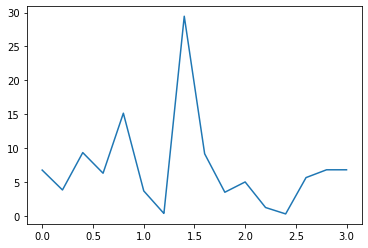

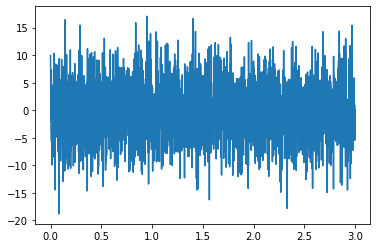

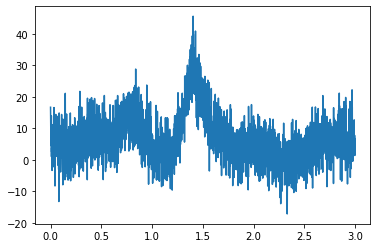

range of filtsig = range(50, 2949)


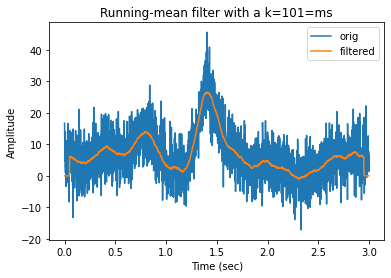

In [2]:
srate = 1000
time = np.arange(0,3,1/srate) # 3 seconds
n = len(time)
p = 15 # poles for random interpolation

# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
ampl = np.interp(np.linspace(0,p,n), np.arange(0,p), np.random.rand(p)*30) # interpolate y = interp(x, xp, fp) where x is the coordinates for interpolation, xp are the poles, fp are the y-coordinates of the xp poles. Will return y which is the same length as x
noise = noiseamp * np.random.randn(n)
signal = ampl + noise

print(np.linspace(0,p,n))
print(np.arange(0,p))
print(np.random.rand(p))

# Plotting for debugging
plt.plot(time, ampl)
plt.show()
plt.plot(time, noise)
plt.show()
plt.plot(time, signal)
plt.show()

# initialize filtered signal vector
filtsig = np.zeros(n)

# implement the running mean filter
k = 50 # filter window is actually k*2+1 
print(f"range of filtsig = {range(k, n-k-1)}")
for i in range(k,n-k-1):
    # each point is the average of k surrounding points
    filtsig[i] = np.mean(signal[i-k:i+k])

# compute window size in ms
windowsize = 1000 * (k*2+1) / srate

# plot the noisy and filtered signals
plt.plot(time, signal, label='orig')
plt.plot(time, filtsig, label='filtered')

plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.title('Running-mean filter with a k=%d=ms' %windowsize)

plt.show()



---
# VIDEO: Gaussian-smooth a time series
---

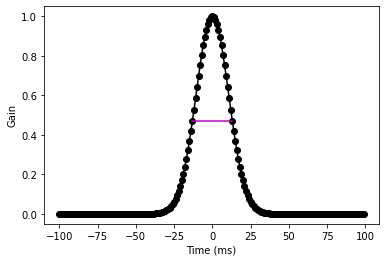

In [3]:
# create signal
srate = 1000 # Hz
time = np.arange(0,3,1/srate)
n = len(time)
p = 15 # poles for random interpolation

# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
ampl = np.interp(linspace(1,p,n), np.arange(0,p), np.random.rand(p)*30)
noise = noiseamp * np.random.randn(n)
signal = ampl + noise

## Create Gaussian kernel
# full-width half-maximum: the key Gaussian parameter
fwhm = 25 # in ms

# normalized time vector in ms 
k = 100
gtime = 1000*np.arange(-k,k) / srate

# create Gaussian window 
gauswin = np.exp(-(4*np.log(2)*gtime**2) / fwhm**2)

# compute empirical FWHM 
pstPeakHalf = k+np.argmin((gauswin[k:]-0.5)**2) # find the index in gaussian window corresponding to half the maximum value, then square it because there are positive and negative values 
prePeakHalf = np.argmin((gauswin-0.5)**2) # do the same thing but for the first half of the gaussian window before the peak 

empFWHM = gtime[pstPeakHalf] - gtime[prePeakHalf]

# show the Gaussian 
plt.plot(gtime, gauswin, 'ko-')
plt.plot([gtime[prePeakHalf],gtime[pstPeakHalf]], [gauswin[prePeakHalf], gauswin[pstPeakHalf]], 'm')

# then normalize Gaussian to unit energy
gauswin = gauswin / np.sum(gauswin)
plt.xlabel('Time (ms)')
plt.ylabel('Gain')

plt.show()


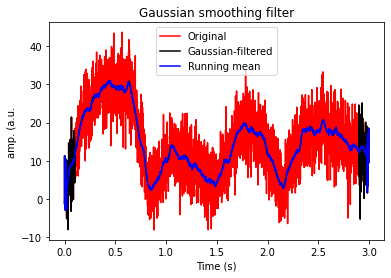

In [4]:
## implement the filter

# initialize filtered signal vector
filtsigG = copy.deepcopy(signal)

# implement the gaussian window filter
for i in range(k+1, n-k-1):
    # each point is the weighted average of k surrounding points
    filtsigG[i] = np.sum(signal[i-k:i+k] * gauswin)

# plot
plt.plot(time, signal,  'r', label='Original')
plt.plot(time, filtsigG, 'k', label='Gaussian-filtered')

plt.xlabel('Time (s)')
plt.ylabel('amp. (a.u.')
plt.legend()
plt.title('Gaussian smoothing filter')

## for comparison, plot mean smoothing filter

# initialize filtered signal vector 
filtsigMean = copy.deepcopy(signal)

# implement the running mean filter
# note: using mk instead of k to avoid confusion with k above
mk = 20 # filter window is actually mk*2+1
for i in range(mk+1, n-mk-1):
    # each point is the average of k surrounding points
    filtsigMean[i] = mean(signal[i-mk:i+mk])
plt.plot(time, filtsigMean, 'b', label='Running mean')
plt.legend()
plt.show()

---
# VIDEO: Gaussian-smooth a spike time series
---

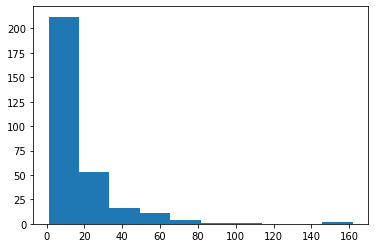

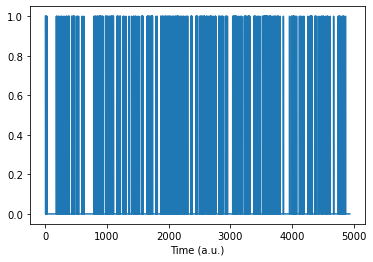

In [5]:
## generate time series of random spikes

# number of spikes
n = 300 

# inter-spike intervals (exponential distribution for bursts)
isi = np.round(np.exp(np.random.randn(n))*10) # this generates an exponential distribution where there is are a lot of short interspike intervals but less longer interspike intervals 
plt.hist(isi)
plt.show()

# generate spike time series
spikets = np.zeros(int(sum(isi))) # add up all the interspike intervals to get the total length of the time vector

for i in range(0, n):
    spikets[int(np.sum(isi[0:i]))] = 1 # loop through each interspike interval value and set to 1. Add them up one by one as you go through the loop to get the right spike times

# plot
plt.plot(spikets)
plt.xlabel('Time (a.u.)')
plt.show()

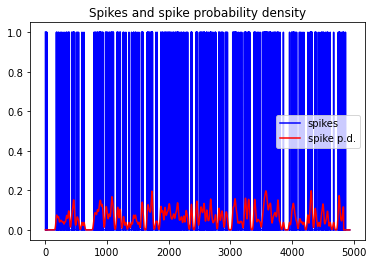

In [6]:
## create and implement Gaussian window

# full-width half-maximum: the key Gaussian parameter
fwhm = 25 # in points

# normalized time vector in ms
k = 100
gtime = np.arange(-k,k)

# create Gaussian window
gauswin = np.exp(-(4*log(2)*gtime**2) / fwhm**2)
gauswin = gauswin / np.sum(gauswin)

# initialize filtered signal vector
filtsigG = np.zeros(len(spikets))

# implement filtered signal vector
filtsigG = np.zeros(len(spikets))

# implement the weighted running mean filter
for i in range(k+1, len(spikets)-k-1):
    filtsigG[i] = np.sum(spikets[i-k:i+k] * gauswin)

# plot the filtered signal (spike probability density)
plt.plot(spikets, 'b', label='spikes')
plt.plot(filtsigG, 'r', label='spike p.d.')
plt.legend()
plt.title('Spikes and spike probability density')
plt.show()

---
# VIDEO: Denoising via TKEO
---

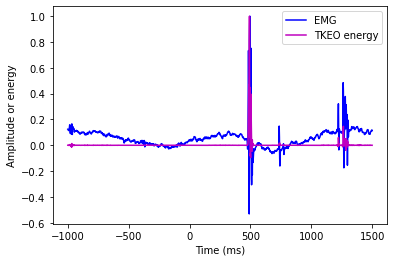

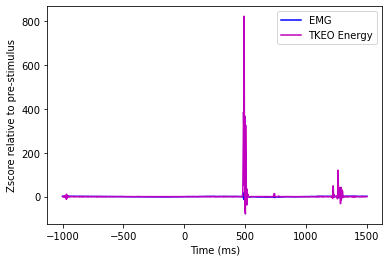

In [7]:
# import data
emgdata = sio.loadmat('emg4TKEO.mat')

# extract needed variables
emgtime = emgdata['emgtime'][0]
emg = emgdata['emg'][0]

# initialize filtered signal
emgf = copy.deepcopy(emg)

# the loop version for interpretability
for i in range(1, len(emgf)-1):
    emgf[i] = emg[i]**2 - emg[i-1]*emg[i+1]


# the vectorized version for speed and elegance
emgf2 = copy.deepcopy(emg)
emgf2[1:-1] = emg[i:-1]**2 - emg[0:-2]*emg[2:] # three vectors, main vector gets squared from 1 to end-1 and you subtract the product of the vector that starts at 0 and ends at end-2 multiplied by the time point ahead which starts at 2 and ends with the last time point

## convert both signal to zscore

# find timepoint zero
time0 = np.argmin(emgtime**2)

# convert original EMG to z-score from time-zero
emgZ = (emg-np.mean(emg[0:time0])) / np.std(emg[0:time0])

# same for filtered EMG energy
emgZf = (emgf - np.mean(emgf[0:time0])) / std(emgf[0:time0])

## plot
# plot "raw" (normalized to max. 1)
plt.plot(emgtime, emg/np.max(emg), 'b', label='EMG')
plt.plot(emgtime, emgf/np.max(emgf), 'm', label='TKEO energy')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude or energy')
plt.legend()

plt.show()

# plot zscored
plt.plot(emgtime, emgZ, 'b', label='EMG')
plt.plot(emgtime, emgZf, 'm', label='TKEO Energy')

plt.xlabel('Time (ms)')
plt.ylabel('Zscore relative to pre-stimulus')
plt.legend()
plt.show()




---
# VIDEO: Median filter to remove spike noise
---

[1002 1917  188 ... 1301 1474 1929]
[1002 1917  188 1609 1740 1484 1537  443  844 1771  184  444  115 1776
  866 1098  827  989 1197 1480 1790 1270 1599 1379  485 1447 1780 1722
  721  875  505  751   54  932  926 1632  730  526  724  102  804   11
 1882    1  370  324 1885  877  845  971  833 1239 1438 1096  632 1981
 1942  576  265 1475  409 1528  713 1944  144  254 1920  831 1020  340
  851 1541  462  237 1571 1750 1852  755 1285  897  303 1214 1812 1477
 1139 1938  957 1594  232 1068  252 1557  281 1258 1959 1355 1105  110
  613  716]


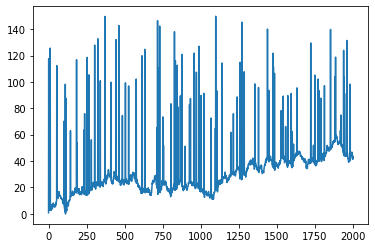

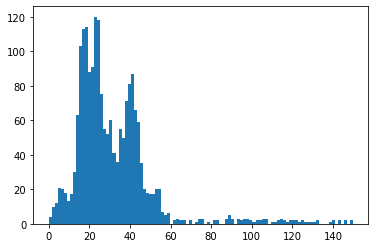

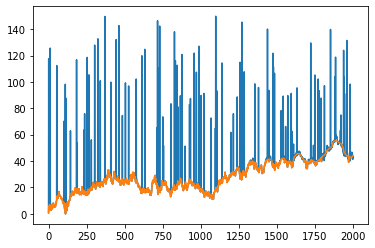

In [8]:
# create signal 
n = 2000
signal = np.cumsum(np.random.randn(n))

# proportion of time points to replace with noise
propnoise = 0.05

# find noise points
noisepnts = np.random.permutation(n) # randomly reorder time points
print(noisepnts)
noisepnts = noisepnts[0:int(n*propnoise)] # choose the first 0.05% of noise points
print(noisepnts)


# generate signal and replace points with noise
signal[noisepnts] = 50 + np.random.rand(len(noisepnts))*100 

plt.plot(signal)
plt.show()

# use hist to pick threshold
plt.hist(signal, 100)
plt.show()

# visual-picked threshold
threshold = 40

# find data values above the threshold 
suprathresh = np.where(signal > threshold)[0]

# initialize the filtered signal 
filtsig = copy.deepcopy(signal)

# loop through suprathreshold points and set to median of k
k = 20 # actual window is k*2+1
for ti in range(len(suprathresh)):

    #lower and upper bounds
    lowbnd = np.max((0, suprathresh[ti] - k))
    uppbnd = np.min((suprathresh[ti]+k, n+1))

    # compute median of surrounding points
    filtsig[suprathresh[ti]] = np.median(signal[lowbnd:uppbnd])

# plot
plt.plot(range(0, n), signal, range(0, n), filtsig)
plt.show()

---
# VIDEO: Remove linear trend
---

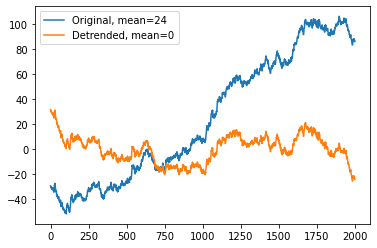

In [9]:
# create signal with linear trend imposed
n = 2000
signal = np.cumsum(np.random.randn(n)) + np.linspace(-30, 30, n)

# linear detrending
detsignal = scipy.signal.detrend(signal)

# get means
omean = np.mean(signal) # original mean
dmean = np.mean(detsignal) # detrended mean

# plot signal and detrended signal 
plt.plot(range(0, n), signal, label='Original, mean=%d' %omean)
plt.plot(range(0, n), detsignal, label='Detrended, mean=%d' %dmean)

plt.legend()
plt.show()

--- 
# VIDEO: Remove nonlinear trend with polynomials
---

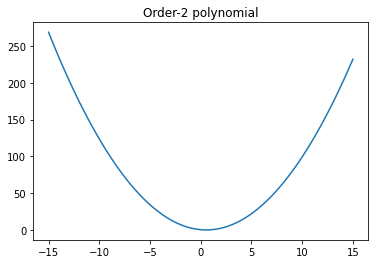

In [10]:
## polynomial intuition

order = 2 
x = np.linspace(-15, 15, 100)

y = np.zeros(len(x))

for i in range(order+1):
    y = y + np.random.randn(1)*x**i

plt.plot(x, y)
plt.title('Order-%d polynomial' %order)
plt.show()

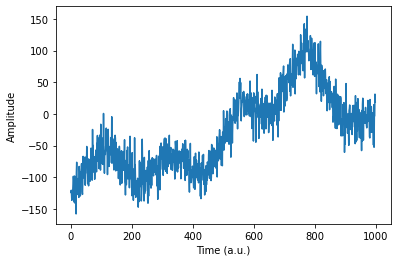

In [11]:
## generate siganl with slow polynomial artifact

n = 1000
t = range(n)
k = 10 # number of poles for random amplitudes

slowdrift = np.interp(np.linspace(1, k, n), np.arange(0, k), 100*np.random.randn(k))
signal = slowdrift + 20*np.random.randn(n)

# plot
plt.plot(t, signal)
plt.xlabel('Time (a.u.)')
plt.ylabel('Amplitude')
plt.show()

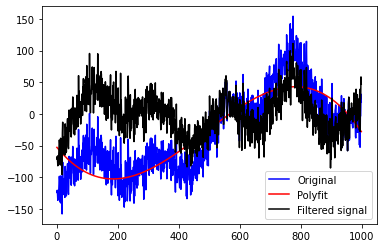

In [12]:
## fit a 3-order polynomial

# polynomial fit (returns coefficients)
p = polyfit(t, signal, 3)

# predicted data is evaluation of polynomial
yHat = polyval(p, t)

# compute residual (the cleaned signal)
residual = signal - yHat

# now polt the fit (the function that will be removed)

plt.plot(t, signal, 'b', label='Original')
plt.plot(t, yHat, 'r', label='Polyfit')
plt.plot(t, residual, 'k', label='Filtered signal')

plt.legend()
plt.show()

<ipython-input-13-21515bac0270>:12: RankWarning: Polyfit may be poorly conditioned
  yHat = np.polyval(polyfit(t, signal, orders[ri]), t)
<ipython-input-13-21515bac0270>:12: RankWarning: Polyfit may be poorly conditioned
  yHat = np.polyval(polyfit(t, signal, orders[ri]), t)
<ipython-input-13-21515bac0270>:12: RankWarning: Polyfit may be poorly conditioned
  yHat = np.polyval(polyfit(t, signal, orders[ri]), t)
<ipython-input-13-21515bac0270>:12: RankWarning: Polyfit may be poorly conditioned
  yHat = np.polyval(polyfit(t, signal, orders[ri]), t)
<ipython-input-13-21515bac0270>:12: RankWarning: Polyfit may be poorly conditioned
  yHat = np.polyval(polyfit(t, signal, orders[ri]), t)
<ipython-input-13-21515bac0270>:12: RankWarning: Polyfit may be poorly conditioned
  yHat = np.polyval(polyfit(t, signal, orders[ri]), t)
<ipython-input-13-21515bac0270>:12: RankWarning: Polyfit may be poorly conditioned
  yHat = np.polyval(polyfit(t, signal, orders[ri]), t)
<ipython-input-13-21515bac0270>:12

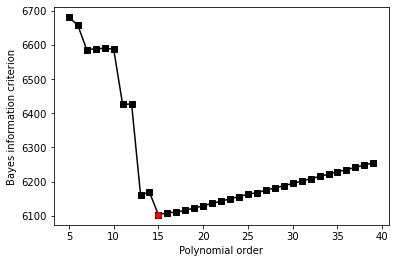

In [13]:
## Bayes information criterion to find optimal order
# possible orders
orders = range(5, 40)

# sum of squared errors (sse is reserved!)
sse1 = np.zeros(len(orders))

# loop through orders
for ri in range(len(orders)):

    # compute polynomial ( fitting time series)
    yHat = np.polyval(polyfit(t, signal, orders[ri]), t)

    # compute fit of model to data (sum of squared errors)
    sse1[ri] = np.sum((yHat-signal)**2)/n

# Bayes information criterion 
bic = n*np.log(sse1) + orders*np.log(n)

# best parameter has lowest BIC
bestP = min(bic)
idx = np.argmin(bic)

# plot the BIC
plt.plot(orders, bic, 'ks-')
plt.plot(orders[idx], bestP, 'ro')
plt.xlabel('Polynomial order')
plt.ylabel('Bayes information criterion')
plt.show()

In [ ]:
## now repeat filter for best (smallest) BIC

# polynomial fit
polycoefs = polyfit(t, signal, orders[idx])

# estimated data based on the coefficients 
yHat = polyval(polycoefs, t)

# filtered signal is residual
filtsig = signal - yHat

## plotting
plt.plot(t, signal, 'b', label='Original')
plt.plot(t, yHat, 'r', label='Polynommial fit')
plt.plot(t, filtsig, 'k', label='Filtered')

plt.xlabel('Time (a.u.)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

---
# VIDEO: Averaging multiple repetitions (time-synchronous averaging)
---

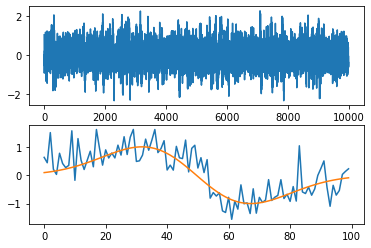

In [14]:
## simulate data

# create event (derivative of Gaussian)
k = 100 # duration of event in time points
event = np.diff(np.exp(-np.linspace(-2,2,k+1)**2))
event = event/np.max(event) # normalize to max = 1

# event onset times
Nevents = 30 
onsettimes = np.random.permutation(10000 - k)
onsettimes = onsettimes[0:Nevents]

# put event into data
data = np.zeros(10000)
for ei in range(Nevents):
    data[onsettimes[ei]:onsettimes[ei]+k] = event

# add noise
data = data + 0.5*np.random.randn(len(data))

# plot data
plt.subplot(211)
plt.plot(data)

# plot one event 
plt.subplot(212)
plt.plot(range(k), data[onsettimes[3]:onsettimes[3]+k])
plt.plot(range(k), event)
plt.show()